## load the libraries

In [71]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import log_loss, f1_score, roc_curve, auc

In [49]:
df = pd.read_csv('sampleData', delimiter='\t', header=None)
print(df.shape)
print(df.columns)

(1615789, 90)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89],
           dtype='int64')


## Missing value treatment
### In our context missing value are -1

In [50]:
missing_col_ids = []
zero_col_ids = []
for col_id in range(df.shape[1]):
    missing_percentage = df[df[col_id] == -1].shape[0] / float(df.shape[0])
    zero_percentage = df[df[col_id] == 0].shape[0] / float(df.shape[0])
    if missing_percentage == 1:
        missing_col_ids.append(col_id)
    if zero_percentage == 1:
        zero_col_ids.append(col_id)
print("Below columns have all missing values")
print(missing_col_ids)
print("Below columns have all zero values")
print(zero_col_ids)

Below columns have all missing values
[55, 56, 74]
Below columns have all zero values
[1, 6, 8, 14, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 35, 36, 38, 39, 41, 42, 50, 52, 57, 60, 66, 68, 69, 70, 71, 72, 73]


### Distributions of zeros

<Container object of 90 artists>

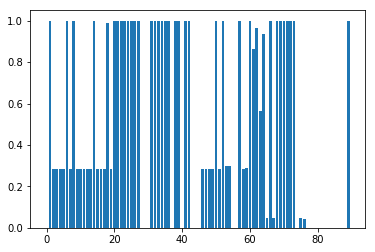

In [51]:
col_id_percentage = {}
for col_id in range(df.shape[1]):
    percentage = df[df[col_id] == 0].shape[0] / float(df.shape[0])
    col_id_percentage[col_id] = percentage
plt.bar(col_id_percentage.keys(), col_id_percentage.values())

## It indicates that there are many columns with all zeros(0) and all missing values(-1). 
### Lets discard them

In [52]:
new_cols = list(set(df.columns) - set(zero_col_ids) - set(missing_col_ids))
df_new = df[new_cols]
print('Number of columns in the new dataframe: %s' % df_new.shape[1])

Number of columns in the new dataframe: 54


## After removing all zero columns

<Container object of 54 artists>

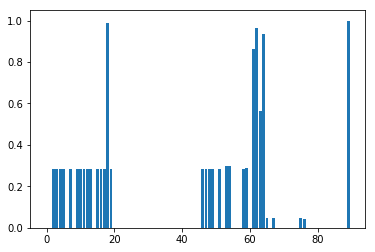

In [53]:
col_id_percentage = {}
for col_id in df_new.columns:
    percentage = df_new[df_new[col_id] == 0].shape[0] / float(df_new.shape[0])
    col_id_percentage[col_id] = percentage
plt.bar(col_id_percentage.keys(), col_id_percentage.values())

### Distribution of nulls : no null values

In [54]:
df_new.isnull().sum().sum()

0

### User Id observation : it is not a primary key, we cannot discard it

In [55]:
print('Total number of records: %s' %df_new.shape[0])
print('Total number of unique user ids %s' %len(df_new[0].unique()))

Total number of records: 1615789
Total number of unique user ids 120034


## This is totally imbalanced dataset

In [56]:
print(df_new[89].value_counts())
print('Percentage of class A(ones) ' + str(df_new[df_new[89] == 0].shape[0]/float(df_new.shape[0]) * 100))
print('Percentage of class B(zeros) ' + str(df_new[df_new[89] == 1].shape[0]/float(df_new.shape[0]) * 100))

0    1614664
1       1125
Name: 89, dtype: int64
Percentage of class A(ones) 99.93037457242251
Percentage of class B(zeros) 0.06962542757748691


## Percentage of missing values 

In [57]:
for col in df_new.columns:
    if df_new[df_new[col] == -1].shape[0] != 0:
        print(col, end='\t')
        print(df_new[df_new[col] == -1].shape[0], end = '\t')
        print(df_new[df_new[col] == -1].shape[0]/float(df_new.shape[0]))

53	456416	0.2824725258062779
54	456416	0.2824725258062779
59	1179	0.0007296744810120628


### convert to categorical data type

In [58]:
for index in range(77, 88, 1):
    df_new.loc[:, index] = df_new[index].astype('category')

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Train, Test and Cross-Validation

In [59]:
x = df_new.loc[:, 0:88]
y = df_new.loc[:, 89]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=44, stratify=y)
x_test, x_cv, y_test, y_cv = train_test_split(x_test, y_test, test_size=0.5, random_state=44, stratify=y_test)

categorical_features = list(df_new.loc[:, 77:88].columns)
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(x_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)
cv_data = lgb.Dataset(x_cv, label=y_cv, categorical_feature=categorical_features, free_raw_data=False)

In [106]:
Metrics = {}

## Dummy Classifier

In [104]:
dummy_model = DummyClassifier()
dummy_model.fit(train_data.data, train_data.label)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [117]:
y_pred = dummy_model.predict_proba(train_data.data)
fpr, tpr, thresholds = roc_curve(train_data.label, y_pred[:, 1])
print("Training data AUC:")
print(auc(fpr, tpr))

y_pred = dummy_model.predict_proba(test_data.data)
fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])
print("Testing data AUC:")
print(auc(fpr, tpr))

Metrics['dummy_classifier'] = { 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc(fpr, tpr),
                                'label': 'dummy classifier, auc: %s'  %auc(fpr, tpr)}

Training data AUC:
0.49966504885435353
Testing data AUC:
0.4996748551557134


## Logistic Classifier

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [110]:
logit_model = LogisticRegression()
logit_model.fit(train_data.data, train_data.label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
y_pred = logit_model.predict_proba(train_data.data)
fpr, tpr, thresholds = roc_curve(train_data.label, y_pred[:, 1])
print("Training data AUC:")
print(auc(fpr, tpr))

y_pred = logit_model.predict_proba(test_data.data)
fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])
print("Testing data AUC:")
print(auc(fpr, tpr))

Metrics['logit_classifier'] = { 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc(fpr, tpr),
                                'label': 'logit classifier, auc: %s'  %auc(fpr, tpr)}

Training data AUC:
0.6984469330570996
Testing data AUC:
0.7095999479768249


## TODO:
### Explore Dataset in LightGBM

## LIGTHGBM MODEL

### Model initialization

In [78]:
parameters = {
#     'scale_pos_weight': 1000,
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.0009,
    'verbose': 100,
    'n_estimators': 150
}

light_gbm_model = lgb.LGBMClassifier(**parameters)
light_gbm_model.fit(train_data.data, train_data.label, eval_set=[(cv_data.data, cv_data.label)], early_stopping_rounds=10, eval_metric='auc')

[1]	valid_0's auc: 0.694316
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.721428
[3]	valid_0's auc: 0.731921
[4]	valid_0's auc: 0.737216
[5]	valid_0's auc: 0.73041
[6]	valid_0's auc: 0.737255
[7]	valid_0's auc: 0.736703
[8]	valid_0's auc: 0.738633
[9]	valid_0's auc: 0.739066
[10]	valid_0's auc: 0.740478
[11]	valid_0's auc: 0.741173
[12]	valid_0's auc: 0.740193
[13]	valid_0's auc: 0.739514
[14]	valid_0's auc: 0.739484
[15]	valid_0's auc: 0.740557
[16]	valid_0's auc: 0.74132
[17]	valid_0's auc: 0.741693
[18]	valid_0's auc: 0.742497
[19]	valid_0's auc: 0.742227
[20]	valid_0's auc: 0.742907
[21]	valid_0's auc: 0.742442
[22]	valid_0's auc: 0.742659
[23]	valid_0's auc: 0.742874
[24]	valid_0's auc: 0.742004
[25]	valid_0's auc: 0.742051
[26]	valid_0's auc: 0.742196
[27]	valid_0's auc: 0.742229
[28]	valid_0's auc: 0.742875
[29]	valid_0's auc: 0.743301
[30]	valid_0's auc: 0.743626
[31]	valid_0's auc: 0.743907
[32]	valid_0's auc: 0.744254
[33]	valid_0's auc: 0

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
        boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.5, is_unbalance='true',
        learning_rate=0.0009, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=100)

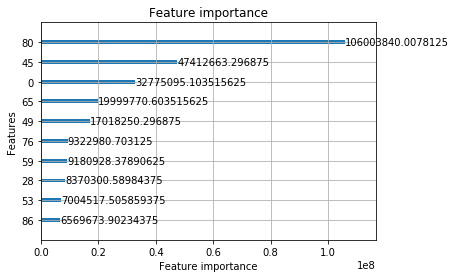

In [84]:
lgb.plot_importance(light_gbm_model, importance_type='gain', max_num_features=10)
##TODO: if time permits, check the distribution of 45, 80 and 49 columns and build a model only using these 10 features

In [85]:
y_pred = light_gbm_model.predict_proba(train_data.data)
fpr, tpr, thresholds = roc_curve(train_data.label, y_pred[:, 1])
print("Training data AUC:")
print(auc(fpr, tpr))

y_pred = light_gbm_model.predict_proba(test_data.data)
fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])
print("Testing data AUC:")
print(auc(fpr, tpr))

Training data AUC:
0.8938602757307587
Testing data AUC:
0.7370271026291314


In [91]:
from sklearn.model_selection import GridSearchCV

# LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
#         boosting='gbdt', boosting_type='gbdt', class_weight=None,
#         colsample_bytree=1.0, feature_fraction=0.5, is_unbalance='true',
#         learning_rate=0.0009, max_depth=-1, metric='auc',
#         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#         n_estimators=150, n_jobs=-1, num_leaves=31, objective='binary',
#         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
#         subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
#         verbose=100)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.0009,
    'verbose': 100,
    'n_estimators': 150
}

light_gbm_model = lgb.LGBMClassifier(**parameters)
param_grid = {
    'learning_rate': [0.0006, 0.0009, 0.0012],
    'feature_fraction': [0.55],
    'min_data_in_leaf': [5000], 
    'max_depth': [18],
    'num_leaves': [30, 40],
    'n_estimators': [140, 150, 160],
#     'scale_pos_weight': [3]
}

light_gbm_model_gs = GridSearchCV(light_gbm_model, param_grid)

In [92]:
light_gbm_model_gs.fit(train_data.data, train_data.label, eval_set=[(cv_data.data, cv_data.label)], early_stopping_rounds=10, eval_metric='auc')

[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.691613
[3]	valid_0's auc: 0.708164
[4]	valid_0's auc: 0.71017
[5]	valid_0's auc: 0.710846
[6]	valid_0's auc: 0.717108
[7]	valid_0's auc: 0.718448
[8]	valid_0's auc: 0.721537
[9]	valid_0's auc: 0.723642
[10]	valid_0's auc: 0.725976
[11]	valid_0's auc: 0.725369
[12]	valid_0's auc: 0.725536
[13]	valid_0's auc: 0.725342
[14]	valid_0's auc: 0.724629
[15]	valid_0's auc: 0.72506
[16]	valid_0's auc: 0.724044
[17]	valid_0's auc: 0.723276
[18]	valid_0's auc: 0.721508
[19]	valid_0's auc: 0.721203
[20]	valid_0's auc: 0.719937
Early stopping, best iteration is:
[10]	valid_0's auc: 0.725976


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.67864
[3]	valid_0's auc: 0.6964
[4]	valid_0's auc: 0.704636
[5]	valid_0's auc: 0.70732
[6]	valid_0's auc: 0.713501
[7]	valid_0's auc: 0.716684
[8]	valid_0's auc: 0.72023
[9]	valid_0's auc: 0.722379
[10]	valid_0's auc: 0.723698
[11]	valid_0's auc: 0.723448
[12]	valid_0's auc: 0.724132
[13]	valid_0's auc: 0.725119
[14]	valid_0's auc: 0.725761
[15]	valid_0's auc: 0.727157
[16]	valid_0's auc: 0.726675
[17]	valid_0's auc: 0.726942
[18]	valid_0's auc: 0.726466
[19]	valid_0's auc: 0.726913
[20]	valid_0's auc: 0.726736
[21]	valid_0's auc: 0.727737
[22]	valid_0's auc: 0.729298
[23]	valid_0's auc: 0.729399
[24]	valid_0's auc: 0.73177
[25]	valid_0's auc: 0.733058
[26]	valid_0's auc: 0.734036
[27]	valid_0's auc: 0.73471
[28]	valid_0's auc: 0.735633
[29]	valid_0's auc: 0.736153
[30]	valid_0's auc: 0.737108
[31]	valid_0's auc: 0.737714
[32]	valid_0's auc: 0.73793
[33]	valid_0's auc: 0.73859

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.712813
[3]	valid_0's auc: 0.716061
[4]	valid_0's auc: 0.718436
[5]	valid_0's auc: 0.719539
[6]	valid_0's auc: 0.724847
[7]	valid_0's auc: 0.724514
[8]	valid_0's auc: 0.727018
[9]	valid_0's auc: 0.727953
[10]	valid_0's auc: 0.731239
[11]	valid_0's auc: 0.730771
[12]	valid_0's auc: 0.73265
[13]	valid_0's auc: 0.732556
[14]	valid_0's auc: 0.731913
[15]	valid_0's auc: 0.733157
[16]	valid_0's auc: 0.732793
[17]	valid_0's auc: 0.732526
[18]	valid_0's auc: 0.732587
[19]	valid_0's auc: 0.732585
[20]	valid_0's auc: 0.731673
[21]	valid_0's auc: 0.7334
[22]	valid_0's auc: 0.73617
[23]	valid_0's auc: 0.737488
[24]	valid_0's auc: 0.73974
[25]	valid_0's auc: 0.74034
[26]	valid_0's auc: 0.742529
[27]	valid_0's auc: 0.743078
[28]	valid_0's auc: 0.744264
[29]	valid_0's auc: 0.744662
[30]	valid_0's auc: 0.74442
[31]	valid_0's auc: 0.745147
[32]	valid_0's auc: 0.745076
[33]	valid_0's auc: 0.7449

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.703753
[3]	valid_0's auc: 0.712507
[4]	valid_0's auc: 0.712844
[5]	valid_0's auc: 0.712822
[6]	valid_0's auc: 0.719059
[7]	valid_0's auc: 0.719891
[8]	valid_0's auc: 0.722161
[9]	valid_0's auc: 0.724698
[10]	valid_0's auc: 0.726431
[11]	valid_0's auc: 0.726748
[12]	valid_0's auc: 0.726044
[13]	valid_0's auc: 0.725367
[14]	valid_0's auc: 0.725185
[15]	valid_0's auc: 0.726311
[16]	valid_0's auc: 0.725224
[17]	valid_0's auc: 0.724378
[18]	valid_0's auc: 0.723335
[19]	valid_0's auc: 0.722565
[20]	valid_0's auc: 0.721545
[21]	valid_0's auc: 0.72238
Early stopping, best iteration is:
[11]	valid_0's auc: 0.726748


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.675395
[3]	valid_0's auc: 0.696465
[4]	valid_0's auc: 0.703879
[5]	valid_0's auc: 0.705924
[6]	valid_0's auc: 0.710982
[7]	valid_0's auc: 0.715191
[8]	valid_0's auc: 0.717811
[9]	valid_0's auc: 0.720415
[10]	valid_0's auc: 0.721327
[11]	valid_0's auc: 0.721191
[12]	valid_0's auc: 0.722219
[13]	valid_0's auc: 0.722702
[14]	valid_0's auc: 0.723488
[15]	valid_0's auc: 0.724535
[16]	valid_0's auc: 0.723306
[17]	valid_0's auc: 0.723796
[18]	valid_0's auc: 0.723257
[19]	valid_0's auc: 0.722873
[20]	valid_0's auc: 0.723081
[21]	valid_0's auc: 0.724007
[22]	valid_0's auc: 0.726162
[23]	valid_0's auc: 0.726732
[24]	valid_0's auc: 0.727592
[25]	valid_0's auc: 0.728702
[26]	valid_0's auc: 0.730919
[27]	valid_0's auc: 0.73235
[28]	valid_0's auc: 0.732962
[29]	valid_0's auc: 0.733709
[30]	valid_0's auc: 0.734528
[31]	valid_0's auc: 0.735122
[32]	valid_0's auc: 0.735595
[33]	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.715929
[3]	valid_0's auc: 0.720725
[4]	valid_0's auc: 0.721992
[5]	valid_0's auc: 0.721325
[6]	valid_0's auc: 0.726589
[7]	valid_0's auc: 0.726561
[8]	valid_0's auc: 0.731603
[9]	valid_0's auc: 0.734104
[10]	valid_0's auc: 0.736356
[11]	valid_0's auc: 0.736369
[12]	valid_0's auc: 0.736265
[13]	valid_0's auc: 0.735243
[14]	valid_0's auc: 0.734826
[15]	valid_0's auc: 0.735421
[16]	valid_0's auc: 0.7343
[17]	valid_0's auc: 0.733837
[18]	valid_0's auc: 0.733131
[19]	valid_0's auc: 0.73236
[20]	valid_0's auc: 0.731772
[21]	valid_0's auc: 0.733241
Early stopping, best iteration is:
[11]	valid_0's auc: 0.736369


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.691613
[3]	valid_0's auc: 0.708164
[4]	valid_0's auc: 0.71017
[5]	valid_0's auc: 0.710846
[6]	valid_0's auc: 0.717108
[7]	valid_0's auc: 0.718448
[8]	valid_0's auc: 0.721537
[9]	valid_0's auc: 0.723642
[10]	valid_0's auc: 0.725976
[11]	valid_0's auc: 0.725369
[12]	valid_0's auc: 0.725536
[13]	valid_0's auc: 0.725342
[14]	valid_0's auc: 0.724629
[15]	valid_0's auc: 0.72506
[16]	valid_0's auc: 0.724044
[17]	valid_0's auc: 0.723276
[18]	valid_0's auc: 0.721508
[19]	valid_0's auc: 0.721203
[20]	valid_0's auc: 0.719937
Early stopping, best iteration is:
[10]	valid_0's auc: 0.725976


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.67864
[3]	valid_0's auc: 0.6964
[4]	valid_0's auc: 0.704636
[5]	valid_0's auc: 0.70732
[6]	valid_0's auc: 0.713501
[7]	valid_0's auc: 0.716684
[8]	valid_0's auc: 0.72023
[9]	valid_0's auc: 0.722379
[10]	valid_0's auc: 0.723698
[11]	valid_0's auc: 0.723448
[12]	valid_0's auc: 0.724132
[13]	valid_0's auc: 0.725119
[14]	valid_0's auc: 0.725761
[15]	valid_0's auc: 0.727157
[16]	valid_0's auc: 0.726675
[17]	valid_0's auc: 0.726942
[18]	valid_0's auc: 0.726466
[19]	valid_0's auc: 0.726913
[20]	valid_0's auc: 0.726736
[21]	valid_0's auc: 0.727737
[22]	valid_0's auc: 0.729298
[23]	valid_0's auc: 0.729399
[24]	valid_0's auc: 0.73177
[25]	valid_0's auc: 0.733058
[26]	valid_0's auc: 0.734036
[27]	valid_0's auc: 0.73471
[28]	valid_0's auc: 0.735633
[29]	valid_0's auc: 0.736153
[30]	valid_0's auc: 0.737108
[31]	valid_0's auc: 0.737714
[32]	valid_0's auc: 0.73793
[33]	valid_0's auc: 0.73859

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.712813
[3]	valid_0's auc: 0.716061
[4]	valid_0's auc: 0.718436
[5]	valid_0's auc: 0.719539
[6]	valid_0's auc: 0.724847
[7]	valid_0's auc: 0.724514
[8]	valid_0's auc: 0.727018
[9]	valid_0's auc: 0.727953
[10]	valid_0's auc: 0.731239
[11]	valid_0's auc: 0.730771
[12]	valid_0's auc: 0.73265
[13]	valid_0's auc: 0.732556
[14]	valid_0's auc: 0.731913
[15]	valid_0's auc: 0.733157
[16]	valid_0's auc: 0.732793
[17]	valid_0's auc: 0.732526
[18]	valid_0's auc: 0.732587
[19]	valid_0's auc: 0.732585
[20]	valid_0's auc: 0.731673
[21]	valid_0's auc: 0.7334
[22]	valid_0's auc: 0.73617
[23]	valid_0's auc: 0.737488
[24]	valid_0's auc: 0.73974
[25]	valid_0's auc: 0.74034
[26]	valid_0's auc: 0.742529
[27]	valid_0's auc: 0.743078
[28]	valid_0's auc: 0.744264
[29]	valid_0's auc: 0.744662
[30]	valid_0's auc: 0.74442
[31]	valid_0's auc: 0.745147
[32]	valid_0's auc: 0.745076
[33]	valid_0's auc: 0.7449

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.703753
[3]	valid_0's auc: 0.712507
[4]	valid_0's auc: 0.712844
[5]	valid_0's auc: 0.712822
[6]	valid_0's auc: 0.719059
[7]	valid_0's auc: 0.719891
[8]	valid_0's auc: 0.722161
[9]	valid_0's auc: 0.724698
[10]	valid_0's auc: 0.726431
[11]	valid_0's auc: 0.726748
[12]	valid_0's auc: 0.726044
[13]	valid_0's auc: 0.725367
[14]	valid_0's auc: 0.725185
[15]	valid_0's auc: 0.726311
[16]	valid_0's auc: 0.725224
[17]	valid_0's auc: 0.724378
[18]	valid_0's auc: 0.723335
[19]	valid_0's auc: 0.722565
[20]	valid_0's auc: 0.721545
[21]	valid_0's auc: 0.72238
Early stopping, best iteration is:
[11]	valid_0's auc: 0.726748


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.675395
[3]	valid_0's auc: 0.696465
[4]	valid_0's auc: 0.703879
[5]	valid_0's auc: 0.705924
[6]	valid_0's auc: 0.710982
[7]	valid_0's auc: 0.715191
[8]	valid_0's auc: 0.717811
[9]	valid_0's auc: 0.720415
[10]	valid_0's auc: 0.721327
[11]	valid_0's auc: 0.721191
[12]	valid_0's auc: 0.722219
[13]	valid_0's auc: 0.722702
[14]	valid_0's auc: 0.723488
[15]	valid_0's auc: 0.724535
[16]	valid_0's auc: 0.723306
[17]	valid_0's auc: 0.723796
[18]	valid_0's auc: 0.723257
[19]	valid_0's auc: 0.722873
[20]	valid_0's auc: 0.723081
[21]	valid_0's auc: 0.724007
[22]	valid_0's auc: 0.726162
[23]	valid_0's auc: 0.726732
[24]	valid_0's auc: 0.727592
[25]	valid_0's auc: 0.728702
[26]	valid_0's auc: 0.730919
[27]	valid_0's auc: 0.73235
[28]	valid_0's auc: 0.732962
[29]	valid_0's auc: 0.733709
[30]	valid_0's auc: 0.734528
[31]	valid_0's auc: 0.735122
[32]	valid_0's auc: 0.735595
[33]	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.715929
[3]	valid_0's auc: 0.720725
[4]	valid_0's auc: 0.721992
[5]	valid_0's auc: 0.721325
[6]	valid_0's auc: 0.726589
[7]	valid_0's auc: 0.726561
[8]	valid_0's auc: 0.731603
[9]	valid_0's auc: 0.734104
[10]	valid_0's auc: 0.736356
[11]	valid_0's auc: 0.736369
[12]	valid_0's auc: 0.736265
[13]	valid_0's auc: 0.735243
[14]	valid_0's auc: 0.734826
[15]	valid_0's auc: 0.735421
[16]	valid_0's auc: 0.7343
[17]	valid_0's auc: 0.733837
[18]	valid_0's auc: 0.733131
[19]	valid_0's auc: 0.73236
[20]	valid_0's auc: 0.731772
[21]	valid_0's auc: 0.733241
Early stopping, best iteration is:
[11]	valid_0's auc: 0.736369


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.691613
[3]	valid_0's auc: 0.708164
[4]	valid_0's auc: 0.71017
[5]	valid_0's auc: 0.710846
[6]	valid_0's auc: 0.717108
[7]	valid_0's auc: 0.718448
[8]	valid_0's auc: 0.721537
[9]	valid_0's auc: 0.723642
[10]	valid_0's auc: 0.725976
[11]	valid_0's auc: 0.725369
[12]	valid_0's auc: 0.725536
[13]	valid_0's auc: 0.725342
[14]	valid_0's auc: 0.724629
[15]	valid_0's auc: 0.72506
[16]	valid_0's auc: 0.724044
[17]	valid_0's auc: 0.723276
[18]	valid_0's auc: 0.721508
[19]	valid_0's auc: 0.721203
[20]	valid_0's auc: 0.719937
Early stopping, best iteration is:
[10]	valid_0's auc: 0.725976


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.67864
[3]	valid_0's auc: 0.6964
[4]	valid_0's auc: 0.704636
[5]	valid_0's auc: 0.70732
[6]	valid_0's auc: 0.713501
[7]	valid_0's auc: 0.716684
[8]	valid_0's auc: 0.72023
[9]	valid_0's auc: 0.722379
[10]	valid_0's auc: 0.723698
[11]	valid_0's auc: 0.723448
[12]	valid_0's auc: 0.724132
[13]	valid_0's auc: 0.725119
[14]	valid_0's auc: 0.725761
[15]	valid_0's auc: 0.727157
[16]	valid_0's auc: 0.726675
[17]	valid_0's auc: 0.726942
[18]	valid_0's auc: 0.726466
[19]	valid_0's auc: 0.726913
[20]	valid_0's auc: 0.726736
[21]	valid_0's auc: 0.727737
[22]	valid_0's auc: 0.729298
[23]	valid_0's auc: 0.729399
[24]	valid_0's auc: 0.73177
[25]	valid_0's auc: 0.733058
[26]	valid_0's auc: 0.734036
[27]	valid_0's auc: 0.73471
[28]	valid_0's auc: 0.735633
[29]	valid_0's auc: 0.736153
[30]	valid_0's auc: 0.737108
[31]	valid_0's auc: 0.737714
[32]	valid_0's auc: 0.73793
[33]	valid_0's auc: 0.73859

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.712813
[3]	valid_0's auc: 0.716061
[4]	valid_0's auc: 0.718436
[5]	valid_0's auc: 0.719539
[6]	valid_0's auc: 0.724847
[7]	valid_0's auc: 0.724514
[8]	valid_0's auc: 0.727018
[9]	valid_0's auc: 0.727953
[10]	valid_0's auc: 0.731239
[11]	valid_0's auc: 0.730771
[12]	valid_0's auc: 0.73265
[13]	valid_0's auc: 0.732556
[14]	valid_0's auc: 0.731913
[15]	valid_0's auc: 0.733157
[16]	valid_0's auc: 0.732793
[17]	valid_0's auc: 0.732526
[18]	valid_0's auc: 0.732587
[19]	valid_0's auc: 0.732585
[20]	valid_0's auc: 0.731673
[21]	valid_0's auc: 0.7334
[22]	valid_0's auc: 0.73617
[23]	valid_0's auc: 0.737488
[24]	valid_0's auc: 0.73974
[25]	valid_0's auc: 0.74034
[26]	valid_0's auc: 0.742529
[27]	valid_0's auc: 0.743078
[28]	valid_0's auc: 0.744264
[29]	valid_0's auc: 0.744662
[30]	valid_0's auc: 0.74442
[31]	valid_0's auc: 0.745147
[32]	valid_0's auc: 0.745076
[33]	valid_0's auc: 0.7449

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.703753
[3]	valid_0's auc: 0.712507
[4]	valid_0's auc: 0.712844
[5]	valid_0's auc: 0.712822
[6]	valid_0's auc: 0.719059
[7]	valid_0's auc: 0.719891
[8]	valid_0's auc: 0.722161
[9]	valid_0's auc: 0.724698
[10]	valid_0's auc: 0.726431
[11]	valid_0's auc: 0.726748
[12]	valid_0's auc: 0.726044
[13]	valid_0's auc: 0.725367
[14]	valid_0's auc: 0.725185
[15]	valid_0's auc: 0.726311
[16]	valid_0's auc: 0.725224
[17]	valid_0's auc: 0.724378
[18]	valid_0's auc: 0.723335
[19]	valid_0's auc: 0.722565
[20]	valid_0's auc: 0.721545
[21]	valid_0's auc: 0.72238
Early stopping, best iteration is:
[11]	valid_0's auc: 0.726748


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.675395
[3]	valid_0's auc: 0.696465
[4]	valid_0's auc: 0.703879
[5]	valid_0's auc: 0.705924
[6]	valid_0's auc: 0.710982
[7]	valid_0's auc: 0.715191
[8]	valid_0's auc: 0.717811
[9]	valid_0's auc: 0.720415
[10]	valid_0's auc: 0.721327
[11]	valid_0's auc: 0.721191
[12]	valid_0's auc: 0.722219
[13]	valid_0's auc: 0.722702
[14]	valid_0's auc: 0.723488
[15]	valid_0's auc: 0.724535
[16]	valid_0's auc: 0.723306
[17]	valid_0's auc: 0.723796
[18]	valid_0's auc: 0.723257
[19]	valid_0's auc: 0.722873
[20]	valid_0's auc: 0.723081
[21]	valid_0's auc: 0.724007
[22]	valid_0's auc: 0.726162
[23]	valid_0's auc: 0.726732
[24]	valid_0's auc: 0.727592
[25]	valid_0's auc: 0.728702
[26]	valid_0's auc: 0.730919
[27]	valid_0's auc: 0.73235
[28]	valid_0's auc: 0.732962
[29]	valid_0's auc: 0.733709
[30]	valid_0's auc: 0.734528
[31]	valid_0's auc: 0.735122
[32]	valid_0's auc: 0.735595
[33]	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.715929
[3]	valid_0's auc: 0.720725
[4]	valid_0's auc: 0.721992
[5]	valid_0's auc: 0.721325
[6]	valid_0's auc: 0.726589
[7]	valid_0's auc: 0.726561
[8]	valid_0's auc: 0.731603
[9]	valid_0's auc: 0.734104
[10]	valid_0's auc: 0.736356
[11]	valid_0's auc: 0.736369
[12]	valid_0's auc: 0.736265
[13]	valid_0's auc: 0.735243
[14]	valid_0's auc: 0.734826
[15]	valid_0's auc: 0.735421
[16]	valid_0's auc: 0.7343
[17]	valid_0's auc: 0.733837
[18]	valid_0's auc: 0.733131
[19]	valid_0's auc: 0.73236
[20]	valid_0's auc: 0.731772
[21]	valid_0's auc: 0.733241
Early stopping, best iteration is:
[11]	valid_0's auc: 0.736369


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.699316
[3]	valid_0's auc: 0.712236
[4]	valid_0's auc: 0.717398
[5]	valid_0's auc: 0.716954
[6]	valid_0's auc: 0.722294
[7]	valid_0's auc: 0.720814
[8]	valid_0's auc: 0.723306
[9]	valid_0's auc: 0.724259
[10]	valid_0's auc: 0.725966
[11]	valid_0's auc: 0.723964
[12]	valid_0's auc: 0.72397
[13]	valid_0's auc: 0.724057
[14]	valid_0's auc: 0.723843
[15]	valid_0's auc: 0.723997
[16]	valid_0's auc: 0.7239
[17]	valid_0's auc: 0.723466
[18]	valid_0's auc: 0.723239
[19]	valid_0's auc: 0.722871
[20]	valid_0's auc: 0.722257
Early stopping, best iteration is:
[10]	valid_0's auc: 0.725966


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.69795
[3]	valid_0's auc: 0.711768
[4]	valid_0's auc: 0.716215
[5]	valid_0's auc: 0.720014
[6]	valid_0's auc: 0.722411
[7]	valid_0's auc: 0.724248
[8]	valid_0's auc: 0.725848
[9]	valid_0's auc: 0.727714
[10]	valid_0's auc: 0.729014
[11]	valid_0's auc: 0.728663
[12]	valid_0's auc: 0.730433
[13]	valid_0's auc: 0.731048
[14]	valid_0's auc: 0.73107
[15]	valid_0's auc: 0.732312
[16]	valid_0's auc: 0.732669
[17]	valid_0's auc: 0.732943
[18]	valid_0's auc: 0.732195
[19]	valid_0's auc: 0.731306
[20]	valid_0's auc: 0.730724
[21]	valid_0's auc: 0.731338
[22]	valid_0's auc: 0.735061
[23]	valid_0's auc: 0.735721
[24]	valid_0's auc: 0.737517
[25]	valid_0's auc: 0.738159
[26]	valid_0's auc: 0.739525
[27]	valid_0's auc: 0.739485
[28]	valid_0's auc: 0.740263
[29]	valid_0's auc: 0.741143
[30]	valid_0's auc: 0.741909
[31]	valid_0's auc: 0.742619
[32]	valid_0's auc: 0.742833
[33]	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696617
[3]	valid_0's auc: 0.711878
[4]	valid_0's auc: 0.715978
[5]	valid_0's auc: 0.72024
[6]	valid_0's auc: 0.7223
[7]	valid_0's auc: 0.720457
[8]	valid_0's auc: 0.722725
[9]	valid_0's auc: 0.723927
[10]	valid_0's auc: 0.726071
[11]	valid_0's auc: 0.725346
[12]	valid_0's auc: 0.725947
[13]	valid_0's auc: 0.726908
[14]	valid_0's auc: 0.726825
[15]	valid_0's auc: 0.727554
[16]	valid_0's auc: 0.727209
[17]	valid_0's auc: 0.726989
[18]	valid_0's auc: 0.726916
[19]	valid_0's auc: 0.726422
[20]	valid_0's auc: 0.727025
[21]	valid_0's auc: 0.728197
[22]	valid_0's auc: 0.733209
[23]	valid_0's auc: 0.73465
[24]	valid_0's auc: 0.73789
[25]	valid_0's auc: 0.73821
[26]	valid_0's auc: 0.740169
[27]	valid_0's auc: 0.739924
[28]	valid_0's auc: 0.741577
[29]	valid_0's auc: 0.742323
[30]	valid_0's auc: 0.742418
[31]	valid_0's auc: 0.743382
[32]	valid_0's auc: 0.743541
[33]	valid_0's auc: 0.743

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696872
[3]	valid_0's auc: 0.711075
[4]	valid_0's auc: 0.715211
[5]	valid_0's auc: 0.717047
[6]	valid_0's auc: 0.722356
[7]	valid_0's auc: 0.720364
[8]	valid_0's auc: 0.721275
[9]	valid_0's auc: 0.723165
[10]	valid_0's auc: 0.723833
[11]	valid_0's auc: 0.722049
[12]	valid_0's auc: 0.7213
[13]	valid_0's auc: 0.721368
[14]	valid_0's auc: 0.720819
[15]	valid_0's auc: 0.720798
[16]	valid_0's auc: 0.721096
[17]	valid_0's auc: 0.721304
[18]	valid_0's auc: 0.719741
[19]	valid_0's auc: 0.719844
[20]	valid_0's auc: 0.719677
Early stopping, best iteration is:
[10]	valid_0's auc: 0.723833


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696867
[3]	valid_0's auc: 0.708886
[4]	valid_0's auc: 0.714565
[5]	valid_0's auc: 0.718827
[6]	valid_0's auc: 0.721561
[7]	valid_0's auc: 0.723785
[8]	valid_0's auc: 0.726264
[9]	valid_0's auc: 0.72761
[10]	valid_0's auc: 0.728568
[11]	valid_0's auc: 0.728041
[12]	valid_0's auc: 0.729133
[13]	valid_0's auc: 0.729599
[14]	valid_0's auc: 0.730231
[15]	valid_0's auc: 0.730999
[16]	valid_0's auc: 0.731405
[17]	valid_0's auc: 0.731705
[18]	valid_0's auc: 0.730762
[19]	valid_0's auc: 0.730492
[20]	valid_0's auc: 0.729967
[21]	valid_0's auc: 0.731388
[22]	valid_0's auc: 0.735243
[23]	valid_0's auc: 0.735629
[24]	valid_0's auc: 0.737907
[25]	valid_0's auc: 0.738511
[26]	valid_0's auc: 0.740578
[27]	valid_0's auc: 0.740831
[28]	valid_0's auc: 0.74162
[29]	valid_0's auc: 0.741589
[30]	valid_0's auc: 0.741543
[31]	valid_0's auc: 0.742139
[32]	valid_0's auc: 0.742424
[33]	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.713924
[3]	valid_0's auc: 0.726181
[4]	valid_0's auc: 0.727552
[5]	valid_0's auc: 0.73182
[6]	valid_0's auc: 0.732599
[7]	valid_0's auc: 0.730368
[8]	valid_0's auc: 0.731791
[9]	valid_0's auc: 0.732591
[10]	valid_0's auc: 0.732905
[11]	valid_0's auc: 0.732789
[12]	valid_0's auc: 0.734024
[13]	valid_0's auc: 0.734875
[14]	valid_0's auc: 0.734298
[15]	valid_0's auc: 0.734602
[16]	valid_0's auc: 0.733921
[17]	valid_0's auc: 0.733633
[18]	valid_0's auc: 0.732857
[19]	valid_0's auc: 0.732559
[20]	valid_0's auc: 0.732267
[21]	valid_0's auc: 0.733521
[22]	valid_0's auc: 0.73899
[23]	valid_0's auc: 0.740807
[24]	valid_0's auc: 0.743966
[25]	valid_0's auc: 0.743804
[26]	valid_0's auc: 0.745608
[27]	valid_0's auc: 0.746041
[28]	valid_0's auc: 0.747
[29]	valid_0's auc: 0.748076
[30]	valid_0's auc: 0.748601
[31]	valid_0's auc: 0.748932
[32]	valid_0's auc: 0.749094
[33]	valid_0's auc: 0.74

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.699316
[3]	valid_0's auc: 0.712236
[4]	valid_0's auc: 0.717398
[5]	valid_0's auc: 0.716954
[6]	valid_0's auc: 0.722294
[7]	valid_0's auc: 0.720814
[8]	valid_0's auc: 0.723306
[9]	valid_0's auc: 0.724259
[10]	valid_0's auc: 0.725966
[11]	valid_0's auc: 0.723964
[12]	valid_0's auc: 0.72397
[13]	valid_0's auc: 0.724057
[14]	valid_0's auc: 0.723843
[15]	valid_0's auc: 0.723997
[16]	valid_0's auc: 0.7239
[17]	valid_0's auc: 0.723466
[18]	valid_0's auc: 0.723239
[19]	valid_0's auc: 0.722871
[20]	valid_0's auc: 0.722257
Early stopping, best iteration is:
[10]	valid_0's auc: 0.725966


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.69795
[3]	valid_0's auc: 0.711768
[4]	valid_0's auc: 0.716215
[5]	valid_0's auc: 0.720014
[6]	valid_0's auc: 0.722411
[7]	valid_0's auc: 0.724248
[8]	valid_0's auc: 0.725848
[9]	valid_0's auc: 0.727714
[10]	valid_0's auc: 0.729014
[11]	valid_0's auc: 0.728663
[12]	valid_0's auc: 0.730433
[13]	valid_0's auc: 0.731048
[14]	valid_0's auc: 0.73107
[15]	valid_0's auc: 0.732312
[16]	valid_0's auc: 0.732669
[17]	valid_0's auc: 0.732943
[18]	valid_0's auc: 0.732195
[19]	valid_0's auc: 0.731306
[20]	valid_0's auc: 0.730724
[21]	valid_0's auc: 0.731338
[22]	valid_0's auc: 0.735061
[23]	valid_0's auc: 0.735721
[24]	valid_0's auc: 0.737517
[25]	valid_0's auc: 0.738159
[26]	valid_0's auc: 0.739525
[27]	valid_0's auc: 0.739485
[28]	valid_0's auc: 0.740263
[29]	valid_0's auc: 0.741143
[30]	valid_0's auc: 0.741909
[31]	valid_0's auc: 0.742619
[32]	valid_0's auc: 0.742833
[33]	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696617
[3]	valid_0's auc: 0.711878
[4]	valid_0's auc: 0.715978
[5]	valid_0's auc: 0.72024
[6]	valid_0's auc: 0.7223
[7]	valid_0's auc: 0.720457
[8]	valid_0's auc: 0.722725
[9]	valid_0's auc: 0.723927
[10]	valid_0's auc: 0.726071
[11]	valid_0's auc: 0.725346
[12]	valid_0's auc: 0.725947
[13]	valid_0's auc: 0.726908
[14]	valid_0's auc: 0.726825
[15]	valid_0's auc: 0.727554
[16]	valid_0's auc: 0.727209
[17]	valid_0's auc: 0.726989
[18]	valid_0's auc: 0.726916
[19]	valid_0's auc: 0.726422
[20]	valid_0's auc: 0.727025
[21]	valid_0's auc: 0.728197
[22]	valid_0's auc: 0.733209
[23]	valid_0's auc: 0.73465
[24]	valid_0's auc: 0.73789
[25]	valid_0's auc: 0.73821
[26]	valid_0's auc: 0.740169
[27]	valid_0's auc: 0.739924
[28]	valid_0's auc: 0.741577
[29]	valid_0's auc: 0.742323
[30]	valid_0's auc: 0.742418
[31]	valid_0's auc: 0.743382
[32]	valid_0's auc: 0.743541
[33]	valid_0's auc: 0.743

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696872
[3]	valid_0's auc: 0.711075
[4]	valid_0's auc: 0.715211
[5]	valid_0's auc: 0.717047
[6]	valid_0's auc: 0.722356
[7]	valid_0's auc: 0.720364
[8]	valid_0's auc: 0.721275
[9]	valid_0's auc: 0.723165
[10]	valid_0's auc: 0.723833
[11]	valid_0's auc: 0.722049
[12]	valid_0's auc: 0.7213
[13]	valid_0's auc: 0.721368
[14]	valid_0's auc: 0.720819
[15]	valid_0's auc: 0.720798
[16]	valid_0's auc: 0.721096
[17]	valid_0's auc: 0.721304
[18]	valid_0's auc: 0.719741
[19]	valid_0's auc: 0.719844
[20]	valid_0's auc: 0.719677
Early stopping, best iteration is:
[10]	valid_0's auc: 0.723833


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696867
[3]	valid_0's auc: 0.708886
[4]	valid_0's auc: 0.714565
[5]	valid_0's auc: 0.718827
[6]	valid_0's auc: 0.721561
[7]	valid_0's auc: 0.723785
[8]	valid_0's auc: 0.726264
[9]	valid_0's auc: 0.72761
[10]	valid_0's auc: 0.728568
[11]	valid_0's auc: 0.728041
[12]	valid_0's auc: 0.729133
[13]	valid_0's auc: 0.729599
[14]	valid_0's auc: 0.730231
[15]	valid_0's auc: 0.730999
[16]	valid_0's auc: 0.731405
[17]	valid_0's auc: 0.731705
[18]	valid_0's auc: 0.730762
[19]	valid_0's auc: 0.730492
[20]	valid_0's auc: 0.729967
[21]	valid_0's auc: 0.731388
[22]	valid_0's auc: 0.735243
[23]	valid_0's auc: 0.735629
[24]	valid_0's auc: 0.737907
[25]	valid_0's auc: 0.738511
[26]	valid_0's auc: 0.740578
[27]	valid_0's auc: 0.740831
[28]	valid_0's auc: 0.74162
[29]	valid_0's auc: 0.741589
[30]	valid_0's auc: 0.741543
[31]	valid_0's auc: 0.742139
[32]	valid_0's auc: 0.742424
[33]	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.713924
[3]	valid_0's auc: 0.726181
[4]	valid_0's auc: 0.727552
[5]	valid_0's auc: 0.73182
[6]	valid_0's auc: 0.732599
[7]	valid_0's auc: 0.730368
[8]	valid_0's auc: 0.731791
[9]	valid_0's auc: 0.732591
[10]	valid_0's auc: 0.732905
[11]	valid_0's auc: 0.732789
[12]	valid_0's auc: 0.734024
[13]	valid_0's auc: 0.734875
[14]	valid_0's auc: 0.734298
[15]	valid_0's auc: 0.734602
[16]	valid_0's auc: 0.733921
[17]	valid_0's auc: 0.733633
[18]	valid_0's auc: 0.732857
[19]	valid_0's auc: 0.732559
[20]	valid_0's auc: 0.732267
[21]	valid_0's auc: 0.733521
[22]	valid_0's auc: 0.73899
[23]	valid_0's auc: 0.740807
[24]	valid_0's auc: 0.743966
[25]	valid_0's auc: 0.743804
[26]	valid_0's auc: 0.745608
[27]	valid_0's auc: 0.746041
[28]	valid_0's auc: 0.747
[29]	valid_0's auc: 0.748076
[30]	valid_0's auc: 0.748601
[31]	valid_0's auc: 0.748932
[32]	valid_0's auc: 0.749094
[33]	valid_0's auc: 0.74

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.699316
[3]	valid_0's auc: 0.712236
[4]	valid_0's auc: 0.717398
[5]	valid_0's auc: 0.716954
[6]	valid_0's auc: 0.722294
[7]	valid_0's auc: 0.720814
[8]	valid_0's auc: 0.723306
[9]	valid_0's auc: 0.724259
[10]	valid_0's auc: 0.725966
[11]	valid_0's auc: 0.723964
[12]	valid_0's auc: 0.72397
[13]	valid_0's auc: 0.724057
[14]	valid_0's auc: 0.723843
[15]	valid_0's auc: 0.723997
[16]	valid_0's auc: 0.7239
[17]	valid_0's auc: 0.723466
[18]	valid_0's auc: 0.723239
[19]	valid_0's auc: 0.722871
[20]	valid_0's auc: 0.722257
Early stopping, best iteration is:
[10]	valid_0's auc: 0.725966


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.69795
[3]	valid_0's auc: 0.711768
[4]	valid_0's auc: 0.716215
[5]	valid_0's auc: 0.720014
[6]	valid_0's auc: 0.722411
[7]	valid_0's auc: 0.724248
[8]	valid_0's auc: 0.725848
[9]	valid_0's auc: 0.727714
[10]	valid_0's auc: 0.729014
[11]	valid_0's auc: 0.728663
[12]	valid_0's auc: 0.730433
[13]	valid_0's auc: 0.731048
[14]	valid_0's auc: 0.73107
[15]	valid_0's auc: 0.732312
[16]	valid_0's auc: 0.732669
[17]	valid_0's auc: 0.732943
[18]	valid_0's auc: 0.732195
[19]	valid_0's auc: 0.731306
[20]	valid_0's auc: 0.730724
[21]	valid_0's auc: 0.731338
[22]	valid_0's auc: 0.735061
[23]	valid_0's auc: 0.735721
[24]	valid_0's auc: 0.737517
[25]	valid_0's auc: 0.738159
[26]	valid_0's auc: 0.739525
[27]	valid_0's auc: 0.739485
[28]	valid_0's auc: 0.740263
[29]	valid_0's auc: 0.741143
[30]	valid_0's auc: 0.741909
[31]	valid_0's auc: 0.742619
[32]	valid_0's auc: 0.742833
[33]	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696617
[3]	valid_0's auc: 0.711878
[4]	valid_0's auc: 0.715978
[5]	valid_0's auc: 0.72024
[6]	valid_0's auc: 0.7223
[7]	valid_0's auc: 0.720457
[8]	valid_0's auc: 0.722725
[9]	valid_0's auc: 0.723927
[10]	valid_0's auc: 0.726071
[11]	valid_0's auc: 0.725346
[12]	valid_0's auc: 0.725947
[13]	valid_0's auc: 0.726908
[14]	valid_0's auc: 0.726825
[15]	valid_0's auc: 0.727554
[16]	valid_0's auc: 0.727209
[17]	valid_0's auc: 0.726989
[18]	valid_0's auc: 0.726916
[19]	valid_0's auc: 0.726422
[20]	valid_0's auc: 0.727025
[21]	valid_0's auc: 0.728197
[22]	valid_0's auc: 0.733209
[23]	valid_0's auc: 0.73465
[24]	valid_0's auc: 0.73789
[25]	valid_0's auc: 0.73821
[26]	valid_0's auc: 0.740169
[27]	valid_0's auc: 0.739924
[28]	valid_0's auc: 0.741577
[29]	valid_0's auc: 0.742323
[30]	valid_0's auc: 0.742418
[31]	valid_0's auc: 0.743382
[32]	valid_0's auc: 0.743541
[33]	valid_0's auc: 0.743

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696872
[3]	valid_0's auc: 0.711075
[4]	valid_0's auc: 0.715211
[5]	valid_0's auc: 0.717047
[6]	valid_0's auc: 0.722356
[7]	valid_0's auc: 0.720364
[8]	valid_0's auc: 0.721275
[9]	valid_0's auc: 0.723165
[10]	valid_0's auc: 0.723833
[11]	valid_0's auc: 0.722049
[12]	valid_0's auc: 0.7213
[13]	valid_0's auc: 0.721368
[14]	valid_0's auc: 0.720819
[15]	valid_0's auc: 0.720798
[16]	valid_0's auc: 0.721096
[17]	valid_0's auc: 0.721304
[18]	valid_0's auc: 0.719741
[19]	valid_0's auc: 0.719844
[20]	valid_0's auc: 0.719677
Early stopping, best iteration is:
[10]	valid_0's auc: 0.723833


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.696867
[3]	valid_0's auc: 0.708886
[4]	valid_0's auc: 0.714565
[5]	valid_0's auc: 0.718827
[6]	valid_0's auc: 0.721561
[7]	valid_0's auc: 0.723785
[8]	valid_0's auc: 0.726264
[9]	valid_0's auc: 0.72761
[10]	valid_0's auc: 0.728568
[11]	valid_0's auc: 0.728041
[12]	valid_0's auc: 0.729133
[13]	valid_0's auc: 0.729599
[14]	valid_0's auc: 0.730231
[15]	valid_0's auc: 0.730999
[16]	valid_0's auc: 0.731405
[17]	valid_0's auc: 0.731705
[18]	valid_0's auc: 0.730762
[19]	valid_0's auc: 0.730492
[20]	valid_0's auc: 0.729967
[21]	valid_0's auc: 0.731388
[22]	valid_0's auc: 0.735243
[23]	valid_0's auc: 0.735629
[24]	valid_0's auc: 0.737907
[25]	valid_0's auc: 0.738511
[26]	valid_0's auc: 0.740578
[27]	valid_0's auc: 0.740831
[28]	valid_0's auc: 0.74162
[29]	valid_0's auc: 0.741589
[30]	valid_0's auc: 0.741543
[31]	valid_0's auc: 0.742139
[32]	valid_0's auc: 0.742424
[33]	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.713924
[3]	valid_0's auc: 0.726181
[4]	valid_0's auc: 0.727552
[5]	valid_0's auc: 0.73182
[6]	valid_0's auc: 0.732599
[7]	valid_0's auc: 0.730368
[8]	valid_0's auc: 0.731791
[9]	valid_0's auc: 0.732591
[10]	valid_0's auc: 0.732905
[11]	valid_0's auc: 0.732789
[12]	valid_0's auc: 0.734024
[13]	valid_0's auc: 0.734875
[14]	valid_0's auc: 0.734298
[15]	valid_0's auc: 0.734602
[16]	valid_0's auc: 0.733921
[17]	valid_0's auc: 0.733633
[18]	valid_0's auc: 0.732857
[19]	valid_0's auc: 0.732559
[20]	valid_0's auc: 0.732267
[21]	valid_0's auc: 0.733521
[22]	valid_0's auc: 0.73899
[23]	valid_0's auc: 0.740807
[24]	valid_0's auc: 0.743966
[25]	valid_0's auc: 0.743804
[26]	valid_0's auc: 0.745608
[27]	valid_0's auc: 0.746041
[28]	valid_0's auc: 0.747
[29]	valid_0's auc: 0.748076
[30]	valid_0's auc: 0.748601
[31]	valid_0's auc: 0.748932
[32]	valid_0's auc: 0.749094
[33]	valid_0's auc: 0.74

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.700809
[3]	valid_0's auc: 0.714247
[4]	valid_0's auc: 0.711312
[5]	valid_0's auc: 0.707643
[6]	valid_0's auc: 0.712057
[7]	valid_0's auc: 0.712332
[8]	valid_0's auc: 0.714715
[9]	valid_0's auc: 0.715841
[10]	valid_0's auc: 0.71628
[11]	valid_0's auc: 0.717037
[12]	valid_0's auc: 0.715738
[13]	valid_0's auc: 0.715133
[14]	valid_0's auc: 0.71574
[15]	valid_0's auc: 0.716956
[16]	valid_0's auc: 0.717484
[17]	valid_0's auc: 0.716739
[18]	valid_0's auc: 0.716753
[19]	valid_0's auc: 0.716499
[20]	valid_0's auc: 0.716675
[21]	valid_0's auc: 0.716271
[22]	valid_0's auc: 0.717099
[23]	valid_0's auc: 0.71701
[24]	valid_0's auc: 0.716782
[25]	valid_0's auc: 0.716996
[26]	valid_0's auc: 0.717389
Early stopping, best iteration is:
[16]	valid_0's auc: 0.717484


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.698147
[3]	valid_0's auc: 0.706794
[4]	valid_0's auc: 0.707626
[5]	valid_0's auc: 0.708257
[6]	valid_0's auc: 0.713815
[7]	valid_0's auc: 0.713506
[8]	valid_0's auc: 0.715182
[9]	valid_0's auc: 0.717664
[10]	valid_0's auc: 0.718582
[11]	valid_0's auc: 0.718686
[12]	valid_0's auc: 0.719186
[13]	valid_0's auc: 0.719666
[14]	valid_0's auc: 0.719121
[15]	valid_0's auc: 0.720031
[16]	valid_0's auc: 0.719977
[17]	valid_0's auc: 0.720065
[18]	valid_0's auc: 0.719733
[19]	valid_0's auc: 0.719686
[20]	valid_0's auc: 0.719144
[21]	valid_0's auc: 0.719403
[22]	valid_0's auc: 0.723042
[23]	valid_0's auc: 0.723247
[24]	valid_0's auc: 0.72497
[25]	valid_0's auc: 0.725814
[26]	valid_0's auc: 0.728127
[27]	valid_0's auc: 0.728029
[28]	valid_0's auc: 0.729764
[29]	valid_0's auc: 0.730582
[30]	valid_0's auc: 0.730889
[31]	valid_0's auc: 0.731203
[32]	valid_0's auc: 0.731384
[33]	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.705742
[3]	valid_0's auc: 0.712582
[4]	valid_0's auc: 0.71233
[5]	valid_0's auc: 0.712461
[6]	valid_0's auc: 0.712904
[7]	valid_0's auc: 0.714678
[8]	valid_0's auc: 0.717245
[9]	valid_0's auc: 0.718151
[10]	valid_0's auc: 0.720426
[11]	valid_0's auc: 0.721265
[12]	valid_0's auc: 0.721924
[13]	valid_0's auc: 0.722985
[14]	valid_0's auc: 0.722875
[15]	valid_0's auc: 0.723532
[16]	valid_0's auc: 0.723038
[17]	valid_0's auc: 0.722368
[18]	valid_0's auc: 0.722186
[19]	valid_0's auc: 0.72203
[20]	valid_0's auc: 0.721393
[21]	valid_0's auc: 0.722399
[22]	valid_0's auc: 0.728091
[23]	valid_0's auc: 0.729313
[24]	valid_0's auc: 0.732325
[25]	valid_0's auc: 0.732977
[26]	valid_0's auc: 0.735038
[27]	valid_0's auc: 0.735036
[28]	valid_0's auc: 0.736709
[29]	valid_0's auc: 0.738539
[30]	valid_0's auc: 0.73894
[31]	valid_0's auc: 0.739824
[32]	valid_0's auc: 0.739898
[33]	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.699264
[3]	valid_0's auc: 0.714632
[4]	valid_0's auc: 0.710687
[5]	valid_0's auc: 0.707939
[6]	valid_0's auc: 0.710981
[7]	valid_0's auc: 0.709699
[8]	valid_0's auc: 0.711088
[9]	valid_0's auc: 0.712345
[10]	valid_0's auc: 0.714077
[11]	valid_0's auc: 0.714006
[12]	valid_0's auc: 0.713312
[13]	valid_0's auc: 0.712776
Early stopping, best iteration is:
[3]	valid_0's auc: 0.714632


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.698078
[3]	valid_0's auc: 0.709103
[4]	valid_0's auc: 0.709492
[5]	valid_0's auc: 0.710305
[6]	valid_0's auc: 0.714714
[7]	valid_0's auc: 0.714439
[8]	valid_0's auc: 0.718342
[9]	valid_0's auc: 0.721118
[10]	valid_0's auc: 0.722736
[11]	valid_0's auc: 0.722416
[12]	valid_0's auc: 0.722683
[13]	valid_0's auc: 0.722928
[14]	valid_0's auc: 0.722037
[15]	valid_0's auc: 0.722548
[16]	valid_0's auc: 0.722844
[17]	valid_0's auc: 0.722561
[18]	valid_0's auc: 0.72145
[19]	valid_0's auc: 0.72159
[20]	valid_0's auc: 0.721462
[21]	valid_0's auc: 0.721892
[22]	valid_0's auc: 0.725129
[23]	valid_0's auc: 0.725331
[24]	valid_0's auc: 0.72786
[25]	valid_0's auc: 0.728465
[26]	valid_0's auc: 0.730124
[27]	valid_0's auc: 0.730472
[28]	valid_0's auc: 0.731729
[29]	valid_0's auc: 0.732291
[30]	valid_0's auc: 0.7326
[31]	valid_0's auc: 0.733014
[32]	valid_0's auc: 0.733221
[33]	valid_0's auc: 0.73

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.710744
[3]	valid_0's auc: 0.710901
[4]	valid_0's auc: 0.714407
[5]	valid_0's auc: 0.719468
[6]	valid_0's auc: 0.721198
[7]	valid_0's auc: 0.721733
[8]	valid_0's auc: 0.722326
[9]	valid_0's auc: 0.723347
[10]	valid_0's auc: 0.72555
[11]	valid_0's auc: 0.72551
[12]	valid_0's auc: 0.725525
[13]	valid_0's auc: 0.726177
[14]	valid_0's auc: 0.726057
[15]	valid_0's auc: 0.726168
[16]	valid_0's auc: 0.726394
[17]	valid_0's auc: 0.726056
[18]	valid_0's auc: 0.726024
[19]	valid_0's auc: 0.72601
[20]	valid_0's auc: 0.725988
[21]	valid_0's auc: 0.726672
[22]	valid_0's auc: 0.731366
[23]	valid_0's auc: 0.732596
[24]	valid_0's auc: 0.736051
[25]	valid_0's auc: 0.737074
[26]	valid_0's auc: 0.738365
[27]	valid_0's auc: 0.738837
[28]	valid_0's auc: 0.740088
[29]	valid_0's auc: 0.742026
[30]	valid_0's auc: 0.742834
[31]	valid_0's auc: 0.744038
[32]	valid_0's auc: 0.74409
[33]	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.700809
[3]	valid_0's auc: 0.714247
[4]	valid_0's auc: 0.711312
[5]	valid_0's auc: 0.707643
[6]	valid_0's auc: 0.712057
[7]	valid_0's auc: 0.712332
[8]	valid_0's auc: 0.714715
[9]	valid_0's auc: 0.715841
[10]	valid_0's auc: 0.71628
[11]	valid_0's auc: 0.717037
[12]	valid_0's auc: 0.715738
[13]	valid_0's auc: 0.715133
[14]	valid_0's auc: 0.71574
[15]	valid_0's auc: 0.716956
[16]	valid_0's auc: 0.717484
[17]	valid_0's auc: 0.716739
[18]	valid_0's auc: 0.716753
[19]	valid_0's auc: 0.716499
[20]	valid_0's auc: 0.716675
[21]	valid_0's auc: 0.716271
[22]	valid_0's auc: 0.717099
[23]	valid_0's auc: 0.71701
[24]	valid_0's auc: 0.716782
[25]	valid_0's auc: 0.716996
[26]	valid_0's auc: 0.717389
Early stopping, best iteration is:
[16]	valid_0's auc: 0.717484


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.698147
[3]	valid_0's auc: 0.706794
[4]	valid_0's auc: 0.707626
[5]	valid_0's auc: 0.708257
[6]	valid_0's auc: 0.713815
[7]	valid_0's auc: 0.713506
[8]	valid_0's auc: 0.715182
[9]	valid_0's auc: 0.717664
[10]	valid_0's auc: 0.718582
[11]	valid_0's auc: 0.718686
[12]	valid_0's auc: 0.719186
[13]	valid_0's auc: 0.719666
[14]	valid_0's auc: 0.719121
[15]	valid_0's auc: 0.720031
[16]	valid_0's auc: 0.719977
[17]	valid_0's auc: 0.720065
[18]	valid_0's auc: 0.719733
[19]	valid_0's auc: 0.719686
[20]	valid_0's auc: 0.719144
[21]	valid_0's auc: 0.719403
[22]	valid_0's auc: 0.723042
[23]	valid_0's auc: 0.723247
[24]	valid_0's auc: 0.72497
[25]	valid_0's auc: 0.725814
[26]	valid_0's auc: 0.728127
[27]	valid_0's auc: 0.728029
[28]	valid_0's auc: 0.729764
[29]	valid_0's auc: 0.730582
[30]	valid_0's auc: 0.730889
[31]	valid_0's auc: 0.731203
[32]	valid_0's auc: 0.731384
[33]	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.705742
[3]	valid_0's auc: 0.712582
[4]	valid_0's auc: 0.71233
[5]	valid_0's auc: 0.712461
[6]	valid_0's auc: 0.712904
[7]	valid_0's auc: 0.714678
[8]	valid_0's auc: 0.717245
[9]	valid_0's auc: 0.718151
[10]	valid_0's auc: 0.720426
[11]	valid_0's auc: 0.721265
[12]	valid_0's auc: 0.721924
[13]	valid_0's auc: 0.722985
[14]	valid_0's auc: 0.722875
[15]	valid_0's auc: 0.723532
[16]	valid_0's auc: 0.723038
[17]	valid_0's auc: 0.722368
[18]	valid_0's auc: 0.722186
[19]	valid_0's auc: 0.72203
[20]	valid_0's auc: 0.721393
[21]	valid_0's auc: 0.722399
[22]	valid_0's auc: 0.728091
[23]	valid_0's auc: 0.729313
[24]	valid_0's auc: 0.732325
[25]	valid_0's auc: 0.732977
[26]	valid_0's auc: 0.735038
[27]	valid_0's auc: 0.735036
[28]	valid_0's auc: 0.736709
[29]	valid_0's auc: 0.738539
[30]	valid_0's auc: 0.73894
[31]	valid_0's auc: 0.739824
[32]	valid_0's auc: 0.739898
[33]	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.699264
[3]	valid_0's auc: 0.714632
[4]	valid_0's auc: 0.710687
[5]	valid_0's auc: 0.707939
[6]	valid_0's auc: 0.710981
[7]	valid_0's auc: 0.709699
[8]	valid_0's auc: 0.711088
[9]	valid_0's auc: 0.712345
[10]	valid_0's auc: 0.714077
[11]	valid_0's auc: 0.714006
[12]	valid_0's auc: 0.713312
[13]	valid_0's auc: 0.712776
Early stopping, best iteration is:
[3]	valid_0's auc: 0.714632


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.698078
[3]	valid_0's auc: 0.709103
[4]	valid_0's auc: 0.709492
[5]	valid_0's auc: 0.710305
[6]	valid_0's auc: 0.714714
[7]	valid_0's auc: 0.714439
[8]	valid_0's auc: 0.718342
[9]	valid_0's auc: 0.721118
[10]	valid_0's auc: 0.722736
[11]	valid_0's auc: 0.722416
[12]	valid_0's auc: 0.722683
[13]	valid_0's auc: 0.722928
[14]	valid_0's auc: 0.722037
[15]	valid_0's auc: 0.722548
[16]	valid_0's auc: 0.722844
[17]	valid_0's auc: 0.722561
[18]	valid_0's auc: 0.72145
[19]	valid_0's auc: 0.72159
[20]	valid_0's auc: 0.721462
[21]	valid_0's auc: 0.721892
[22]	valid_0's auc: 0.725129
[23]	valid_0's auc: 0.725331
[24]	valid_0's auc: 0.72786
[25]	valid_0's auc: 0.728465
[26]	valid_0's auc: 0.730124
[27]	valid_0's auc: 0.730472
[28]	valid_0's auc: 0.731729
[29]	valid_0's auc: 0.732291
[30]	valid_0's auc: 0.7326
[31]	valid_0's auc: 0.733014
[32]	valid_0's auc: 0.733221
[33]	valid_0's auc: 0.73

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.710744
[3]	valid_0's auc: 0.710901
[4]	valid_0's auc: 0.714407
[5]	valid_0's auc: 0.719468
[6]	valid_0's auc: 0.721198
[7]	valid_0's auc: 0.721733
[8]	valid_0's auc: 0.722326
[9]	valid_0's auc: 0.723347
[10]	valid_0's auc: 0.72555
[11]	valid_0's auc: 0.72551
[12]	valid_0's auc: 0.725525
[13]	valid_0's auc: 0.726177
[14]	valid_0's auc: 0.726057
[15]	valid_0's auc: 0.726168
[16]	valid_0's auc: 0.726394
[17]	valid_0's auc: 0.726056
[18]	valid_0's auc: 0.726024
[19]	valid_0's auc: 0.72601
[20]	valid_0's auc: 0.725988
[21]	valid_0's auc: 0.726672
[22]	valid_0's auc: 0.731366
[23]	valid_0's auc: 0.732596
[24]	valid_0's auc: 0.736051
[25]	valid_0's auc: 0.737074
[26]	valid_0's auc: 0.738365
[27]	valid_0's auc: 0.738837
[28]	valid_0's auc: 0.740088
[29]	valid_0's auc: 0.742026
[30]	valid_0's auc: 0.742834
[31]	valid_0's auc: 0.744038
[32]	valid_0's auc: 0.74409
[33]	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.684932
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.700809
[3]	valid_0's auc: 0.714247
[4]	valid_0's auc: 0.711312
[5]	valid_0's auc: 0.707643
[6]	valid_0's auc: 0.712057
[7]	valid_0's auc: 0.712332
[8]	valid_0's auc: 0.714715
[9]	valid_0's auc: 0.715841
[10]	valid_0's auc: 0.71628
[11]	valid_0's auc: 0.717037
[12]	valid_0's auc: 0.715738
[13]	valid_0's auc: 0.715133
[14]	valid_0's auc: 0.71574
[15]	valid_0's auc: 0.716956
[16]	valid_0's auc: 0.717484
[17]	valid_0's auc: 0.716739
[18]	valid_0's auc: 0.716753
[19]	valid_0's auc: 0.716499
[20]	valid_0's auc: 0.716675
[21]	valid_0's auc: 0.716271
[22]	valid_0's auc: 0.717099
[23]	valid_0's auc: 0.71701
[24]	valid_0's auc: 0.716782
[25]	valid_0's auc: 0.716996
[26]	valid_0's auc: 0.717389
Early stopping, best iteration is:
[16]	valid_0's auc: 0.717484


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.698147
[3]	valid_0's auc: 0.706794
[4]	valid_0's auc: 0.707626
[5]	valid_0's auc: 0.708257
[6]	valid_0's auc: 0.713815
[7]	valid_0's auc: 0.713506
[8]	valid_0's auc: 0.715182
[9]	valid_0's auc: 0.717664
[10]	valid_0's auc: 0.718582
[11]	valid_0's auc: 0.718686
[12]	valid_0's auc: 0.719186
[13]	valid_0's auc: 0.719666
[14]	valid_0's auc: 0.719121
[15]	valid_0's auc: 0.720031
[16]	valid_0's auc: 0.719977
[17]	valid_0's auc: 0.720065
[18]	valid_0's auc: 0.719733
[19]	valid_0's auc: 0.719686
[20]	valid_0's auc: 0.719144
[21]	valid_0's auc: 0.719403
[22]	valid_0's auc: 0.723042
[23]	valid_0's auc: 0.723247
[24]	valid_0's auc: 0.72497
[25]	valid_0's auc: 0.725814
[26]	valid_0's auc: 0.728127
[27]	valid_0's auc: 0.728029
[28]	valid_0's auc: 0.729764
[29]	valid_0's auc: 0.730582
[30]	valid_0's auc: 0.730889
[31]	valid_0's auc: 0.731203
[32]	valid_0's auc: 0.731384
[33]	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.702766
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.705742
[3]	valid_0's auc: 0.712582
[4]	valid_0's auc: 0.71233
[5]	valid_0's auc: 0.712461
[6]	valid_0's auc: 0.712904
[7]	valid_0's auc: 0.714678
[8]	valid_0's auc: 0.717245
[9]	valid_0's auc: 0.718151
[10]	valid_0's auc: 0.720426
[11]	valid_0's auc: 0.721265
[12]	valid_0's auc: 0.721924
[13]	valid_0's auc: 0.722985
[14]	valid_0's auc: 0.722875
[15]	valid_0's auc: 0.723532
[16]	valid_0's auc: 0.723038
[17]	valid_0's auc: 0.722368
[18]	valid_0's auc: 0.722186
[19]	valid_0's auc: 0.72203
[20]	valid_0's auc: 0.721393
[21]	valid_0's auc: 0.722399
[22]	valid_0's auc: 0.728091
[23]	valid_0's auc: 0.729313
[24]	valid_0's auc: 0.732325
[25]	valid_0's auc: 0.732977
[26]	valid_0's auc: 0.735038
[27]	valid_0's auc: 0.735036
[28]	valid_0's auc: 0.736709
[29]	valid_0's auc: 0.738539
[30]	valid_0's auc: 0.73894
[31]	valid_0's auc: 0.739824
[32]	valid_0's auc: 0.739898
[33]	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.685822
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.699264
[3]	valid_0's auc: 0.714632
[4]	valid_0's auc: 0.710687
[5]	valid_0's auc: 0.707939
[6]	valid_0's auc: 0.710981
[7]	valid_0's auc: 0.709699
[8]	valid_0's auc: 0.711088
[9]	valid_0's auc: 0.712345
[10]	valid_0's auc: 0.714077
[11]	valid_0's auc: 0.714006
[12]	valid_0's auc: 0.713312
[13]	valid_0's auc: 0.712776
Early stopping, best iteration is:
[3]	valid_0's auc: 0.714632


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.680268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.698078
[3]	valid_0's auc: 0.709103
[4]	valid_0's auc: 0.709492
[5]	valid_0's auc: 0.710305
[6]	valid_0's auc: 0.714714
[7]	valid_0's auc: 0.714439
[8]	valid_0's auc: 0.718342
[9]	valid_0's auc: 0.721118
[10]	valid_0's auc: 0.722736
[11]	valid_0's auc: 0.722416
[12]	valid_0's auc: 0.722683
[13]	valid_0's auc: 0.722928
[14]	valid_0's auc: 0.722037
[15]	valid_0's auc: 0.722548
[16]	valid_0's auc: 0.722844
[17]	valid_0's auc: 0.722561
[18]	valid_0's auc: 0.72145
[19]	valid_0's auc: 0.72159
[20]	valid_0's auc: 0.721462
[21]	valid_0's auc: 0.721892
[22]	valid_0's auc: 0.725129
[23]	valid_0's auc: 0.725331
[24]	valid_0's auc: 0.72786
[25]	valid_0's auc: 0.728465
[26]	valid_0's auc: 0.730124
[27]	valid_0's auc: 0.730472
[28]	valid_0's auc: 0.731729
[29]	valid_0's auc: 0.732291
[30]	valid_0's auc: 0.7326
[31]	valid_0's auc: 0.733014
[32]	valid_0's auc: 0.733221
[33]	valid_0's auc: 0.73

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.701756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.710744
[3]	valid_0's auc: 0.710901
[4]	valid_0's auc: 0.714407
[5]	valid_0's auc: 0.719468
[6]	valid_0's auc: 0.721198
[7]	valid_0's auc: 0.721733
[8]	valid_0's auc: 0.722326
[9]	valid_0's auc: 0.723347
[10]	valid_0's auc: 0.72555
[11]	valid_0's auc: 0.72551
[12]	valid_0's auc: 0.725525
[13]	valid_0's auc: 0.726177
[14]	valid_0's auc: 0.726057
[15]	valid_0's auc: 0.726168
[16]	valid_0's auc: 0.726394
[17]	valid_0's auc: 0.726056
[18]	valid_0's auc: 0.726024
[19]	valid_0's auc: 0.72601
[20]	valid_0's auc: 0.725988
[21]	valid_0's auc: 0.726672
[22]	valid_0's auc: 0.731366
[23]	valid_0's auc: 0.732596
[24]	valid_0's auc: 0.736051
[25]	valid_0's auc: 0.737074
[26]	valid_0's auc: 0.738365
[27]	valid_0's auc: 0.738837
[28]	valid_0's auc: 0.740088
[29]	valid_0's auc: 0.742026
[30]	valid_0's auc: 0.742834
[31]	valid_0's auc: 0.744038
[32]	valid_0's auc: 0.74409
[33]	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.700999
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.729539
[3]	valid_0's auc: 0.740438
[4]	valid_0's auc: 0.746059
[5]	valid_0's auc: 0.746114
[6]	valid_0's auc: 0.751085
[7]	valid_0's auc: 0.750301
[8]	valid_0's auc: 0.753411
[9]	valid_0's auc: 0.755436
[10]	valid_0's auc: 0.756354
[11]	valid_0's auc: 0.757198
[12]	valid_0's auc: 0.758134
[13]	valid_0's auc: 0.758687
[14]	valid_0's auc: 0.759353
[15]	valid_0's auc: 0.759832
[16]	valid_0's auc: 0.759706
[17]	valid_0's auc: 0.760193
[18]	valid_0's auc: 0.75956
[19]	valid_0's auc: 0.759556
[20]	valid_0's auc: 0.759258
[21]	valid_0's auc: 0.759756
[22]	valid_0's auc: 0.760763
[23]	valid_0's auc: 0.7609
[24]	valid_0's auc: 0.761557
[25]	valid_0's auc: 0.760854
[26]	valid_0's auc: 0.761253
[27]	valid_0's auc: 0.761624
[28]	valid_0's auc: 0.761959
[29]	valid_0's auc: 0.761891
[30]	valid_0's auc: 0.76172
[31]	valid_0's auc: 0.762092
[32]	valid_0's auc: 0.761879
[33]	valid_0's auc: 0.7

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
        boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.5, is_unbalance='true',
        learning_rate=0.0009, max_depth=-1, metric='auc',
        min_child...silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=100),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.0006, 0.0009, 0.0012], 'feature_fraction': [0.55], 'min_data_in_leaf': [5000], 'max_depth': [18], 'num_leaves': [30, 40], 'n_estimators': [140, 150, 160]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [93]:
print(light_gbm_model_gs.best_estimator_)
print(light_gbm_model_gs.best_params_)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
        boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.55, is_unbalance='true',
        learning_rate=0.0006, max_depth=18, metric='auc',
        min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=5000, min_split_gain=0.0, n_estimators=140,
        n_jobs=-1, num_leaves=30, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=100)
{'feature_fraction': 0.55, 'learning_rate': 0.0006, 'max_depth': 18, 'min_data_in_leaf': 5000, 'n_estimators': 140, 'num_leaves': 30}


In [124]:
y_pred = light_gbm_model_gs.predict_proba(train_data.data)
fpr, tpr, thresholds = roc_curve(train_data.label, y_pred[:, 1])
print("Training data AUC:")
print(auc(fpr, tpr))

y_pred = light_gbm_model_gs.predict_proba(cv_data.data)
fpr, tpr, thresholds = roc_curve(cv_data.label, y_pred[:, 1])
print("CV data AUC:")
print(auc(fpr, tpr))

y_pred = light_gbm_model_gs.predict_proba(test_data.data)
fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])
print("Testing data AUC:")
print(auc(fpr, tpr))

Metrics['ligth_gbm_classifier'] = { 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc(fpr, tpr),
                                'label': 'light gbm classifier, auc: %s'  %auc(fpr, tpr)}

Training data AUC:
0.9008085185055202
CV data AUC:
0.7630158921854103
Testing data AUC:
0.7432769232833643


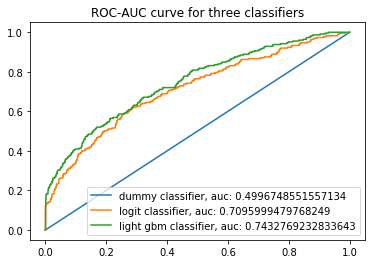

In [127]:
plt.title('ROC-AUC curve for three classifiers')
for classifier in Metrics.keys():
    plt.plot(Metrics[classifier]['fpr'], Metrics[classifier]['tpr'], label=Metrics[classifier]['label'])
plt.legend()
plt.show()

In [121]:
Metrics

{'dummy_classifier': {'auc': 0.4996748551557134,
  'fpr': array([0.00000000e+00, 6.50289689e-04, 1.00000000e+00]),
  'label': 'dummy classifier, auc: 0.4996748551557134',
  'thresholds': array([2, 1, 0]),
  'tpr': array([0., 0., 1.])},
 'ligth_gbm_classifier': {'auc': 0.7432769232833643,
  'fpr': array([0.00000000e+00, 3.09661756e-06, 6.19323513e-06, ...,
         9.99956647e-01, 9.99969034e-01, 1.00000000e+00]),
  'label': 'dummy classifier, auc: 0.7432769232833643',
  'thresholds': array([1.05199217e+00, 5.19921743e-02, 5.10045703e-02, ...,
         8.69605646e-04, 8.64854086e-04, 8.09871723e-04]),
  'tpr': array([0., 0., 0., ..., 1., 1., 1.])},
 'logit_classifier': {'auc': 0.7095999479768249,
  'fpr': array([0.00000000e+00, 3.09661756e-06, 3.40627932e-05, ...,
         9.99702725e-01, 9.99708918e-01, 1.00000000e+00]),
  'label': 'dummy classifier, auc: 0.7095999479768249',
  'thresholds': array([1.03106323e+00, 3.10632321e-02, 2.21107468e-02, ...,
         4.58015507e-05, 4.57752898

## NOTES
#### Lightgbm definitely performs better than a dummy classifier and a logistic regression
#### Using a deep learning model could be the next approach, but againg even a MLP algorithm does not accept the categorical variables directly, we need to encode them and pass it to the model.